In [4]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import json
from collections import OrderedDict
import torchvision
import torchvision.transforms as transforms
import skimage
import joblib
import seaborn as sns

# Preparation

In [7]:
MODEL_FILEDIR = '/scratch/data/TrojAI/object-detection-feb2023-train/models/'
MODEL_NUM = 117
MODEL_SUMMARY_FILEPATH = '/scratch/data/TrojAI/object-detection-feb2023-train/METADATA.csv'
OUTPUT_FILEDIR = '/scratch/jialin/object-detection-feb2023/weight_analysis/extracted_source/'
METADATA = pd.read_csv(MODEL_SUMMARY_FILEPATH)

def num_to_model_id(num):
    return 'id-' + str(100000000+num)[1:]

def load_model(model_num):
    model_id = num_to_model_id(model_num)
    model_filepath = os.path.join(MODEL_FILEDIR, model_id, 'model.pt')
    # model_info_fp = model_filepath + '.stats.json'
    model = torch.load(model_filepath)
    # with open(model_info_fp, 'r') as f:
    #     model_info = json.load(f)
    return model

augmentation_transforms = torchvision.transforms.Compose([torchvision.transforms.ConvertImageDtype(torch.float)])

In [31]:
METADATA.head()

,model_name,converged,master_seed,task_type_level,task_type,source_dataset_background_level,source_dataset_background,source_dataset_foreground_level,source_dataset_foreground,model_architecture,...,val_poisoned_map_large,val_poisoned_mar_1,val_poisoned_mar_10,val_poisoned_mar_100,val_poisoned_mar_small,val_poisoned_mar_medium,val_poisoned_mar_large,val_poisoned_mar_100_per_class,trigger_0.localization_direction_level,trigger_0.localization_direction
0,id-00000000,True,2144392218,0,object_detection,0,cityscapes,0.0,synth-traffic-signs,object_detection:ssd300_vgg16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,id-00000001,True,128105317,0,object_detection,1,gta5,0.0,synth-traffic-signs,object_detection:detr,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,id-00000002,True,180280357,0,object_detection,1,gta5,0.0,synth-traffic-signs,object_detection:detr,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,id-00000003,True,1445239999,0,object_detection,0,cityscapes,0.0,synth-traffic-signs,object_detection:fasterrcnn_resnet50_fpn_v2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,id-00000004,True,1738367397,0,object_detection,1,gta5,0.0,synth-traffic-signs,object_detection:ssd300_vgg16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
augmentation_transforms = transforms.Compose([torchvision.transforms.ConvertImageDtype(torch.float)])
poisoned_imgs, poisoned_imgs_info = [], []
for model_num in range(MODEL_NUM):
    sample_data_dir = os.path.join(MODEL_FILEDIR, num_to_model_id(model_num), 'poisoned-example-data')
    if os.path.exists(sample_data_dir):
        imgs, imgs_info = [], []
        for img_fp in os.listdir(sample_data_dir):
            if img_fp.endswith('.png'):
                img = skimage.io.imread(os.path.join(sample_data_dir, img_fp))
                img = augmentation_transforms(torch.as_tensor(img).permute(2, 0, 1))
                imgs.append(img)
                with open(os.path.join(sample_data_dir, f"{img_fp.split('.')[0]}.json")) as jsonfile:
                    imgs_info.append(json.load(jsonfile))
        poisoned_imgs += imgs
        poisoned_imgs_info += imgs_info

In [52]:
poisoned_model_num = METADATA[METADATA['poisoned'] & (METADATA['model_architecture']=='object_detection:ssd300_vgg16')].sort_values(by='number_classes')['number_classes'].index.tolist()[:5]

In [48]:
METADATA[(~METADATA['poisoned']) & (METADATA['model_architecture']=='object_detection:ssd300_vgg16')].sort_values(by='number_classes')['number_classes']

0       16
54      16
19      16
53      16
47      16
29      16
34      16
42      16
92      18
83      18
81      18
102     18
93      18
27      32
16      32
62      32
6       32
4       32
15      64
36      64
28     128
Name: number_classes, dtype: int64

In [53]:
clean_model_num = METADATA[(~METADATA['poisoned']) & (METADATA['model_architecture']=='object_detection:ssd300_vgg16')].sort_values(by='number_classes')['number_classes'].index.tolist()[:5]

In [121]:
len([p.shape for p in m1.parameters()])

326

### Feature Extraction

In [106]:
def get_model_features(model_filepath):
    model = torch.load(model_filepath)
    model_backbone = model.backbone

    model_name = model._get_name()

    all_backbone_params = []
    for param in model_backbone.parameters():
        all_backbone_params.append(param.data.cpu().numpy())

    features = []
    if model_name == 'FasterRCNN':  # model A
        features = _get_eigen_vals(all_backbone_params, 2, 3)
    elif model_name == 'SSD':  # model B
        features = _get_eigen_vals(all_backbone_params, 2, 5)

    return {'model_class': model_class, 'features': features}


def _get_eigen_vals(model_backbone, idx_low=0, idx_high=3):
    features, feature_lengths = [], []
    num_layers = 0
    for backbone_params in model_backbone.parameters():
        if len(backbone_params.shape) > 2:
            if num_layers >= idx_low and num_layers <= idx_high:
                reshaped_params = backbone_params.reshape(backbone_params.shape[0], -1)
                _, singular_values, _ = torch.linalg.svd(reshaped_params,False)
                squared_singular_values = singular_values**2
                ssv = squared_singular_values.detach().cpu().tolist()
                features += ssv
                feature_lengths.append(len(features))
            num_layers += 1
    return features, feature_lengths

In [52]:
def _get_weight_features(model, num_layer_max=10):
    params = []
    num_layer = 0
    for param in model.parameters():
        axis = None
        if list(param.shape) in ([64, 3, 3, 3], [64, 3, 7, 7]):
            param_3d = torch.flatten(torch.permute(param, (1, 0, 2, 3)), start_dim=2)
            axis = (-1, -2)
        if num_layer < num_layer_max:
            if axis is not None:
                params += torch.amax(param_3d, dim=axis).cpu().tolist()
                params += torch.mean(param_3d, dim=axis).cpu().tolist()
                params += (torch.mean(param_3d, dim=axis) - torch.median(torch.flatten(param_3d, start_dim=1), dim=-1)[0]).cpu().tolist()
                params += torch.median(torch.flatten(param_3d, start_dim=1), dim=-1)[0].cpu().tolist()
                params += torch.sum(param_3d, dim=axis).cpu().tolist()
                # params += torch.linalg.norm(param_3d, ord=2, dim=axis).cpu().tolist()
                # params += (torch.linalg.norm(param_3d, ord='fro', dim=(-1, -2))**2/torch.linalg.norm(param_3d, ord=2, dim=(-1, -2))**2).tolist()
            else:
                params.append(param.max().cpu().tolist())
                params.append(param.mean().cpu().tolist())
                sub = param.mean() - torch.median(param)
                params.append(sub.cpu().tolist())
                params.append(torch.median(param).cpu().tolist())
                params.append(param.sum().cpu().tolist())
                # params.append(torch.linalg.norm(param.reshape(param.shape[0], -1), ord=2).cpu().tolist())
                # params.append((torch.linalg.norm(param.reshape(param.shape[0], -1), ord='fro')**2/torch.linalg.norm(param.reshape(param.shape[0], -1), ord=2)**2).tolist())
            num_layer += 1
    return params


def _get_eigen_features(model):
    min_shape, params = 1, []
    for param in model.parameters():
        if len(param.shape) > min_shape:
            reshaped_param = param.reshape(param.shape[0], -1)
            singular_values = torch.linalg.svd(reshaped_param, False).S
            ssv = torch.square(singular_values)
            params.append(ssv.max().tolist())
            params.append(ssv.mean().tolist())
            params.append((ssv.mean() - torch.median(ssv)).tolist())
            params.append(torch.median(ssv).tolist())
            params.append(ssv.sum().tolist())
            # params.append(ssv.tolist()[:20])
    return params

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
model0, model1 = load_model(0), load_model(1)

In [12]:
md0_bb = [(n, p) for n, p in model0.backbone.named_modules()]

In [21]:
md0_bb[178]

IndexError: list index out of range

In [7]:
model0._get_name(), model1._get_name()

('FasterRCNN', 'SSD')

In [51]:
import seaborn as sns

In [35]:
poisoned_ssd_inds = [ind for ind in METADATA[(METADATA['poisoned']) & (METADATA['model_architecture']=='object_detection:ssd300_vgg16')].index]
clean_ssd_inds = [ind for ind in METADATA[(~METADATA['poisoned']) & (METADATA['model_architecture']=='object_detection:ssd300_vgg16')].index]

In [ ]:
from itertools import product
cka_poisoned_ssd = {'clean_input':{}, 'poisoned_input':{}}
for model_num, cop in list(product(poisoned_ssd_inds, ['clean', 'poisoned'])):
    cka = np.load(os.path.join(OUTPUT_FILEDIR, f'minicka_model_{num_to_model_id(model_num)}_{cop}_input_fulllayer.npy'))
    cka_poisoned_ssd[f'{cop}_input'][model_num] = cka

In [ ]:
cka_clean_ssd = {}
for model_num in clean_ssd_inds:
    cka = np.load(os.path.join(OUTPUT_FILEDIR, f'minicka_model_{num_to_model_id(model_num)}_clean_input_fulllayer.npy'))
    cka_clean_ssd[model_num] = cka

In [37]:
cka_ssd_all_poisoned = {'clean':{}, 'poisoned':{}}
for model_num in clean_ssd_inds:
    cka_ssd_all_poisoned['clean'][model_num] = np.load(os.path.join(OUTPUT_FILEDIR, f'minicka_model_{num_to_model_id(model_num)}_global_poisoned_input_fulllayer.npy'))
for model_num in poisoned_ssd_inds:
    cka_ssd_all_poisoned['poisoned'][model_num] = np.load(os.path.join(OUTPUT_FILEDIR, f'minicka_model_{num_to_model_id(model_num)}_global_poisoned_input_fulllayer.npy'))

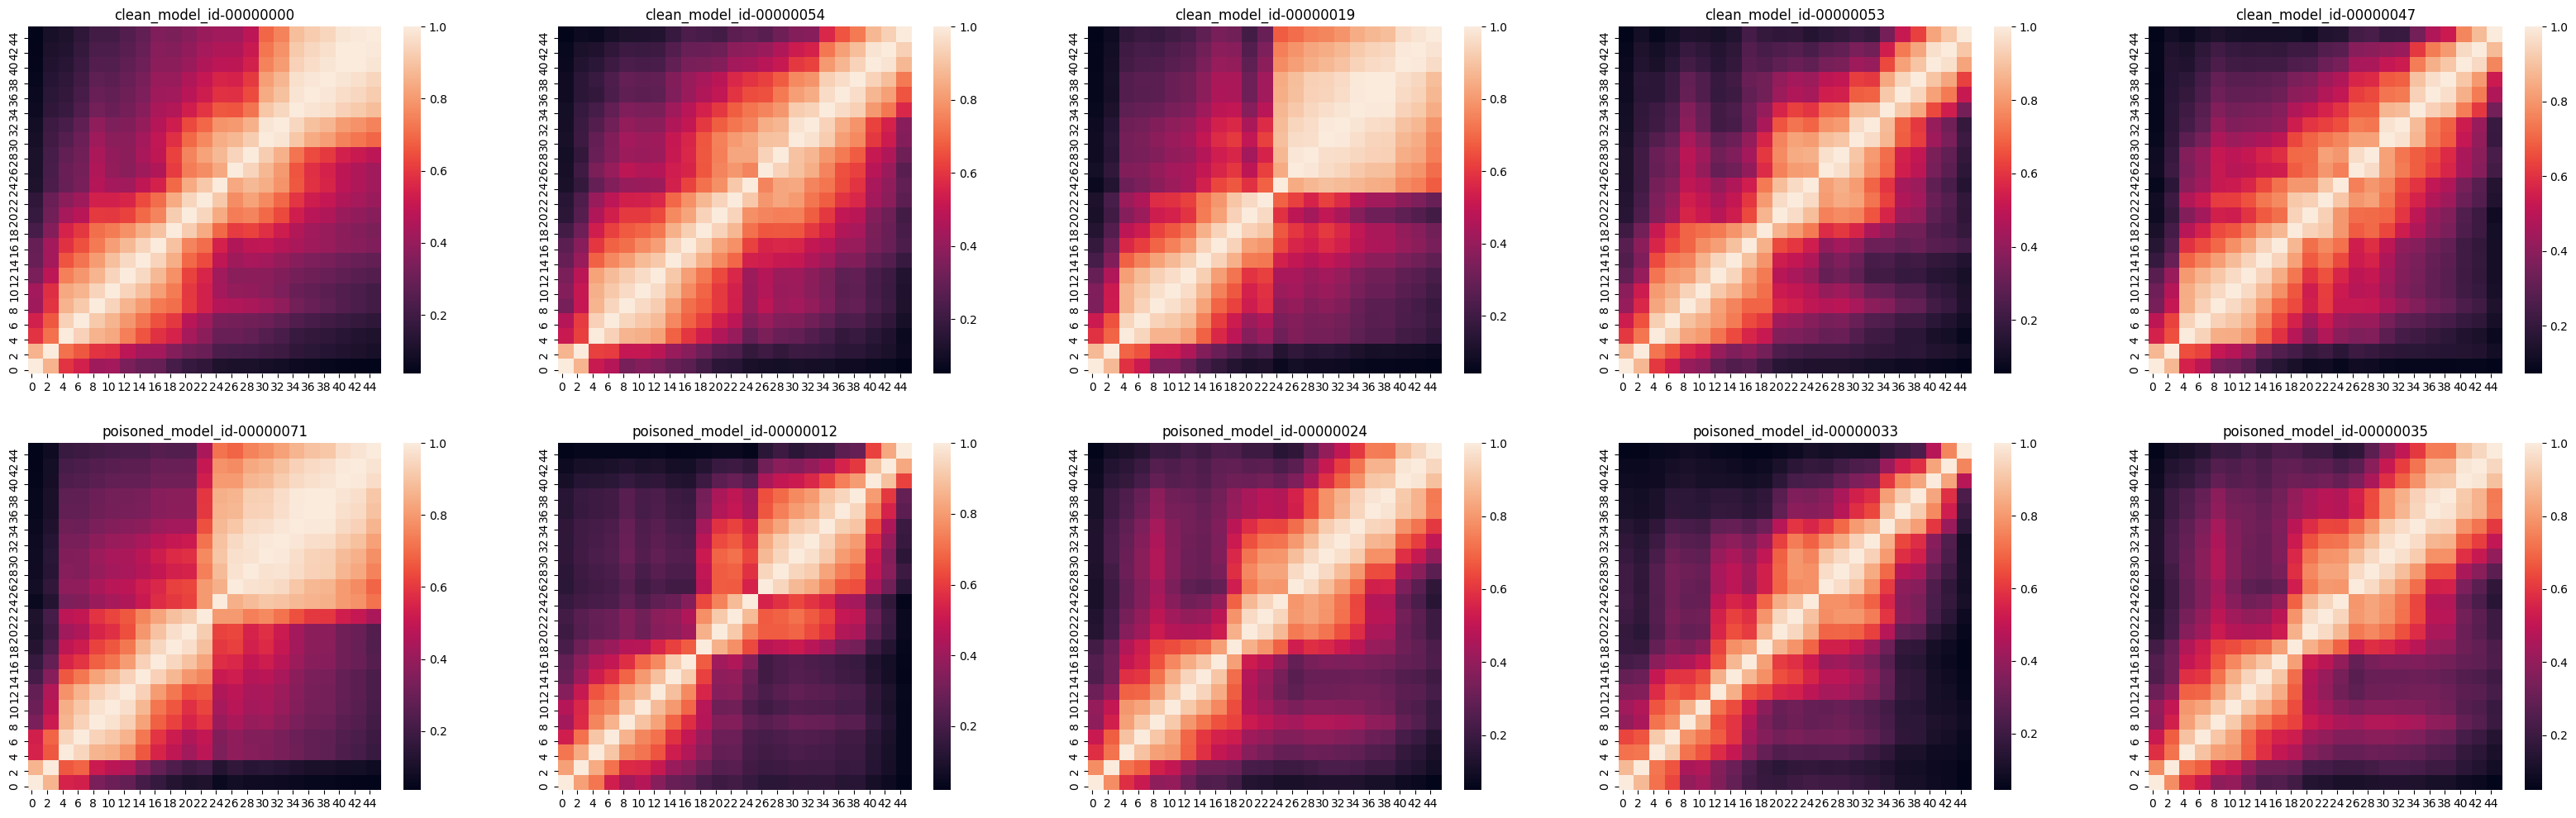

In [57]:
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(40, 12))
model_num_by_cop = {'clean':clean_model_num, 'poisoned':poisoned_model_num}
for row, cop in enumerate(['clean', 'poisoned']):
    model_nums = model_num_by_cop[cop]
    for ind, model_num in enumerate(model_nums):
        cka = cka_ssd_all_poisoned[cop][model_num]
        sns.heatmap(cka_ssd_all_poisoned[cop][model_num], ax = axs[row, ind])
        axs[row, ind].invert_yaxis()
        axs[row, ind].set_title(f'{cop}_model_{num_to_model_id(model_num)}')
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16, 24))
for ind, model_num in enumerate(poisoned_ssd_inds):
    if ind < 4:
        sns.heatmap(cka_poisoned_ssd['clean_input'][model_num], vmin=0, vmax=1, ax = axs[ind, 0])
        axs[ind, 0].set_title(f'poisoned_model_{num_to_model_id(model_num)} with clean input')
        axs[ind, 0].invert_yaxis()
        sns.heatmap(cka_poisoned_ssd['poisoned_input'][model_num], vmin=0, vmax=1, ax = axs[ind, 1])
        axs[ind, 1].invert_yaxis()
        axs[ind, 1].set_title(f'poisoned_model_{num_to_model_id(model_num)} with poisoned input')
plt.show()

In [127]:
X_cka, y_cka = [], []
ssd_inds = [ind for ind in METADATA[METADATA['model_architecture']=='object_detection:ssd300_vgg16'].index]
for model_num in ssd_inds:
    if model_num in clean_ssd_inds:
        cka = cka_clean_ssd[model_num]
        y_cka.append(False)
    else:
        cka = cka_poisoned_ssd['clean_input'][model_num]
        y_cka.append(True)
    features = [cka.min(), cka.max(), np.median(cka), cka.mean(), np.median(cka)-cka.mean()]
    # features += np.amin(cka, axis=-1).tolist()
    # features += np.amax(cka, axis=-1).tolist()
    # features += np.median(cka, axis=-1).tolist()
    # features += np.mean(cka, axis=-1).tolist()
    # features += (np.median(cka, axis=-1) - np.mean(cka, axis=-1)).tolist()
    X_cka.append(features)

In [120]:
X_cka, y_cka = [], []
ssd_inds = [ind for ind in METADATA[METADATA['model_architecture']=='object_detection:ssd300_vgg16'].index]
for model_num in poisoned_ssd_inds:
    cka = cka_poisoned_ssd['clean_input'][model_num]
    X_cka.append([cka.min(), cka.max(), np.median(cka), cka.mean(), np.median(cka)-cka.mean()])
    y_cka.append(False)
    cka = cka_poisoned_ssd['poisoned_input'][model_num]
    y_cka.append(True)
    X_cka.append([cka.min(), cka.max(), np.median(cka), cka.mean(), np.median(cka)-cka.mean()])
    # features += np.amin(cka, axis=-1).tolist()
    # features += np.amax(cka, axis=-1).tolist()
    # features += np.median(cka, axis=-1).tolist()
    # features += np.mean(cka, axis=-1).tolist()
    # features += (np.median(cka, axis=-1) - np.mean(cka, axis=-1)).tolist()

In [66]:
stats_cka = {'clean':[], 'poisoned':[]}
for cop, all_ckas in cka_ssd_all_poisoned.items():
    for cka in all_ckas.values():
        stats_cka[cop].append([cka.min(), cka.max(), np.median(cka), cka.mean(), np.median(cka)-cka.mean()])

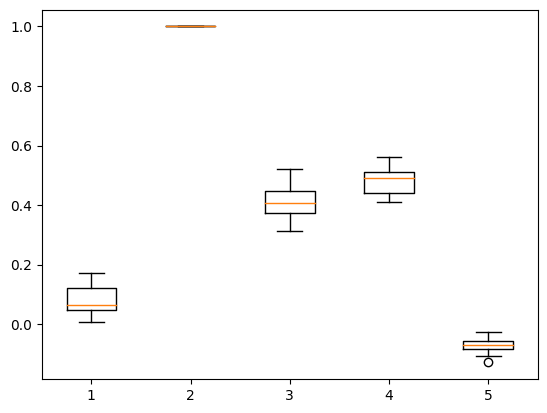

In [77]:
plt.boxplot(np.asarray(stats_cka['poisoned']));

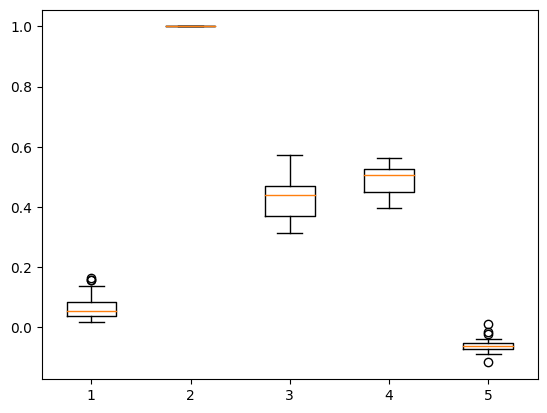

In [78]:
plt.boxplot(np.asarray(stats_cka['clean']));

In [121]:
X_cka = np.asarray(X_cka)

In [122]:
columns = [f'{sts}_l{ind}' for sts, ind in list(product(['min', 'max', 'median', 'mean', 'sub'], range(46)))]
columns += ['poisoned']

In [128]:
cka_stats_df = pd.DataFrame(np.concatenate([X_cka, np.asarray(y_cka).reshape(-1, 1)], axis=-1), columns=['min', 'max', 'median', 'mean', 'sub', 'poisoned'])

In [129]:
melt_df = pd.melt(cka_stats_df, id_vars=['poisoned'])

In [130]:
melt_df.head()

,poisoned,variable,value
0,1.0,min,0.019421
1,0.0,min,0.070733
2,0.0,min,-0.160330
3,1.0,min,0.040814
4,0.0,min,0.004769


In [75]:
melt_df.shape

(6440, 3)

In [77]:
46*28*5

6440

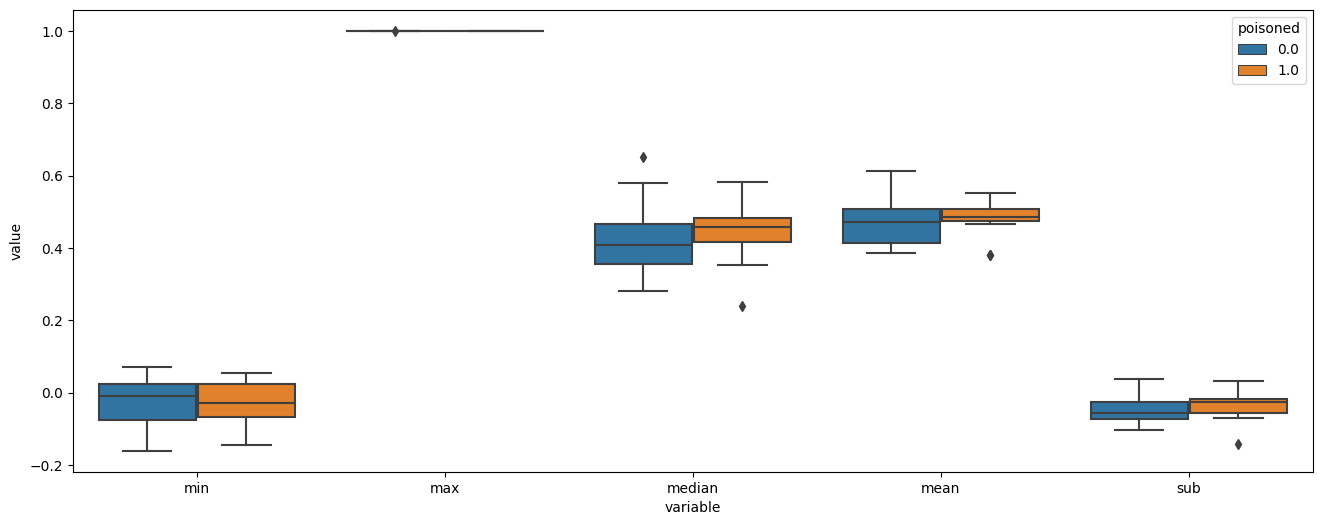

In [131]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.boxplot(data=melt_df, x='variable', y='value', hue='poisoned', ax=ax);

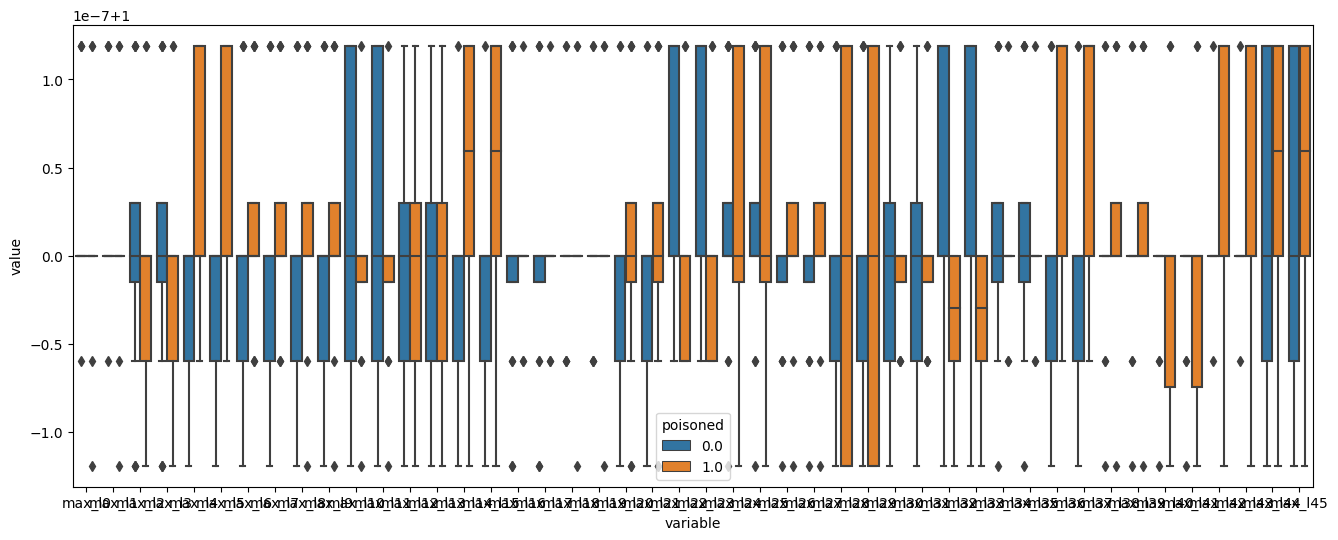

In [81]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.boxplot(data=melt_df.iloc[46*28:46*28*2, :], x='variable', y='value', hue='poisoned', ax=ax);

In [109]:
X_cka[y_cka, 50].min(), X_cka[y_cka, 50].max(), X_cka[np.logical_not(y_cka), 50].min(), X_cka[np.logical_not(y_cka), 50].max()

(0.9999999403953552, 1.0000001192092896, 0.9999998807907104, 1.0)

In [8]:
model0_param, model1_param = sum(p.numel() for p in model0.parameters())/1000.0, sum(p.numel() for p in model1.parameters())/1000.0
model0_param, model1_param

(43333.028, 27889.43)

In [71]:
model0_param, model1_param = sum(p.numel() for p in model0.backbone.parameters())/1000.0, sum(p.numel() for p in model1.backbone.parameters())/1000.0
model0_param, model1_param

(26854.464, 22943.936)

In [ ]:
model0_10 = torch.load('/scratch/data/TrojAI/round10-train-dataset/id-00000000/model.pt')
model0_10_param = sum(p.numel() for p in model0_10.backbone.parameters())/1000.0
model0_10_param = 26799.296

In [ ]:
model1_10_param = 22943.936

In [11]:
import utils.models as model_utils

In [135]:
X, y, X_len = {}, {}, {}
for model_num in tqdm(range(MODEL_NUM)):
    model_id = num_to_model_id(model_num)
    model_filepath = os.path.join(MODEL_FILEDIR, model_id, 'model.pt')
    model, _, model_class = model_utils.load_model(model_filepath)
    model = model.to(device)
    if 'Detr' not in model_class:
        model_backbone = model.backbone
    else:
        model_backbone = model

    feature = []
    
    if 'SSD' in model_class:
        idx_lo, idx_hi = 2, 5
        feature += _get_eigen_vals(model_backbone, idx_lo, idx_hi)[0]
    elif 'RCNN' in model_class:
        idx_lo, idx_hi = 2, 3
        feature += _get_eigen_vals(model_backbone, idx_lo, idx_hi)[0]
    else:
        for idx_lo, idx_hi in [(45, 45), (69, 69), (79, 79), (89, 89)]:
            feature += _get_eigen_vals(model_backbone, idx_lo, idx_hi)[0]

    # feature += _get_eigen_vals(model_backbone, idx_lo, idx_hi)[0]

    # if 'ssd' in model_arch:
    #     idx_lo, idx_hi = 12, 16
    #     eig_val, _ = _get_eigen_vals(model_backbone, idx_lo, idx_hi)
    #     feature += eig_val 
    # else:
    #     for idx_lo, idx_hi in [(2, 5), (25, 31), (57, 64)]:
    #         eig_val, _ = _get_eigen_vals(model_backbone, idx_lo, idx_hi)
    #         feature += eig_val 

    
    # eig_stats = _get_eigen_features(model_backbone)
    # if 'ssd' in model_arch:
    #     feature += eig_stats[12*5:20*5]
    # else:
    #     feature += eig_stats[25*5:30*5]
    #     feature += eig_stats[45*5:47*5]
    #     feature += eig_stats[57*5:]
    # feature += _get_eigen_features(model_backbone)
    # feature += _get_weight_features(model_backbone)
    # if model_arch not in X_len:
    #     X_len[model_arch] = eig_len

    poisoned = METADATA[METADATA['model_name'] == model_id]['poisoned'].item()

    if model_class in X:
        X[model_class].append(feature)
        y[model_class].append(poisoned)
    else:
        X[model_class] = [feature]
        y[model_class] = [poisoned]
    del model

100%|██████████| 117/117 [00:15<00:00,  7.58it/s]


In [14]:
X.keys()

dict_keys(['SSD', 'DetrForObjectDetection', 'FasterRCNN'])

In [ ]:
len(X['SSD'][0]), len(X['DetrForObjectDetection'][0]), len(X['FasterRCNN'][0])

In [31]:
np.unique([len(x) for x in X['DetrForObjectDetection']])

array([256, 768])

In [139]:
X_len['FasterRCNN']

[64]

In [150]:
X_rcnn = np.split(X['FasterRCNN'], X_len['FasterRCNN'], axis=-1)[:-1]
X_ssd = np.split(X['SSD'], X_len['SSD'], axis=-1)[:-1]

In [151]:
X_rcnn_eigen = np.concatenate([x[:, :10] for x in X_rcnn], axis=-1)
X_ssd_eigen = np.concatenate([x[:, :10] for x in X_ssd], axis=-1)
X_rcnn_least_eigen = np.concatenate([x[:, -10:] for x in X_rcnn], axis=-1)
X_ssd_least_eigen = np.concatenate([x[:, -10:] for x in X_ssd], axis=-1)

In [66]:
X_rcnn_c = np.concatenate([x[:, :10] for x in X_rcnn], axis=-1)[y['FasterRCNN'], :]
X_rcnn_p = np.concatenate([x[:, :10] for x in X_rcnn], axis=-1)[np.logical_not(y['FasterRCNN']), :]

In [152]:
X_rcnn_stats = np.concatenate([[np.max(x, axis=-1), np.min(x, axis=-1), np.mean(x, axis=-1), np.median(x, axis=-1), np.linalg.norm(x, axis=-1, ord=2)] for x in X_rcnn], axis=0).T
X_ssd_stats = np.concatenate([[np.max(x, axis=-1), np.min(x, axis=-1), np.mean(x, axis=-1), np.median(x, axis=-1), np.linalg.norm(x, axis=-1, ord=2)] for x in X_ssd], axis=0).T

In [125]:
X_rcnn_stats.shape

(28, 50)

In [127]:
stats_ind = np.arange(15, 1640, 5)

In [128]:
len(stats_ind)

325

45, 69, 79, 89

In [133]:
arr_poisoned = np.asarray(X['DetrForObjectDetection'])[y['DetrForObjectDetection']][:, stats_ind[50:100]]
arr_clean = np.asarray(X['DetrForObjectDetection'])[np.logical_not(y['DetrForObjectDetection'])][:, stats_ind[50:100]]

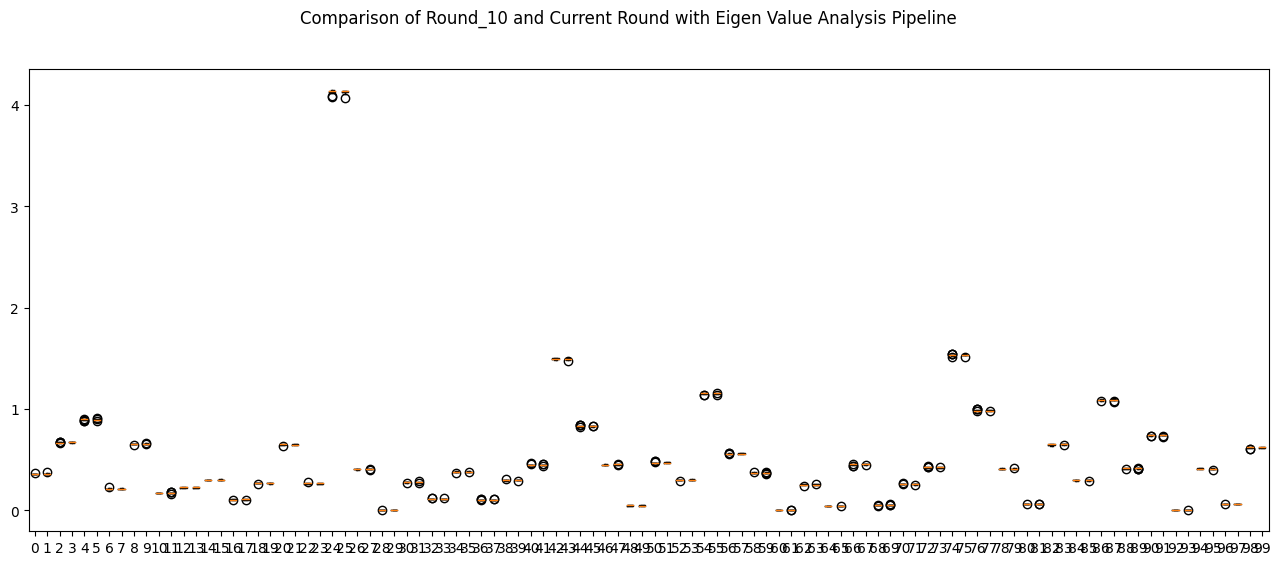

In [134]:
fig, ax = plt.subplots(figsize=(16, 6))
ncol = arr_poisoned.shape[-1]*2
bar1 = ax.boxplot(arr_poisoned, positions=range(0, ncol, 2))
bar2 = ax.boxplot(arr_clean, positions=range(1, ncol, 2))
plt.suptitle('Comparison of Round_10 and Current Round with Eigen Value Analysis Pipeline')
# fig.tight_layout()
plt.show()

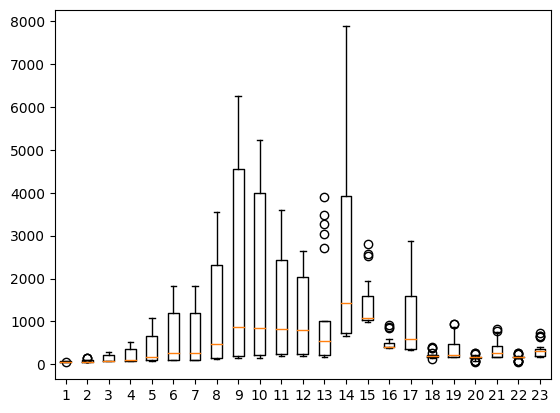

In [131]:
plt.boxplot();

In [12]:
X_len['FasterRCNN'], X_len['SSD']

([64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64],
 [27, 64, 128, 128, 256, 256, 256, 512, 512, 512, 512])

In [26]:
np.unique(y['FasterRCNN'], return_counts=True), np.unique(y['SSD'], return_counts=True)

((array([False,  True]), array([16, 12])),
 (array([False,  True]), array([16, 12])))

In [25]:
with open(os.path.join(OUTPUT_FILEDIR, 'X.json'), 'w') as outfile:
    json.dump(X, outfile)
with open(os.path.join(OUTPUT_FILEDIR, 'y.json'), 'w') as outfile:
    json.dump(y, outfile)

In [30]:
model = load_model(0)
model_arch = model._get_name()
print(model_arch)
print(len(_get_weight_features(model)))
print(len(_get_eigen_features(model)))

FasterRCNN
1266
360


In [28]:
model = load_model(1)
model_arch = model._get_name()
print(len(_get_weight_features(model)))
print(len(_get_eigen_features(model)))

438
175


In [170]:
model = load_model(1)
model.eval()
sample_data_dir = '/scratch/data/TrojAI/object-detection-jan2023-train/models/id-00000001/poisoned-example-data'
imgs, imgs_info = [], []
for img_fp in os.listdir(sample_data_dir):
    if img_fp.endswith('.png'):
        img = skimage.io.imread(os.path.join(sample_data_dir, img_fp))
        img = augmentation_transforms(torch.as_tensor(img).permute(2, 0, 1))
        imgs.append(img)
        with open(os.path.join(sample_data_dir, f"{img_fp.split('.')[0]}.json")) as jsonfile:
            imgs_info.append(json.load(jsonfile))

In [181]:
trigger_fp = '/scratch/data/TrojAI/object-detection-jan2023-train/models/id-00000001/trigger_0.png'
trig = skimage.io.imread(trigger_fp)
trig = augmentation_transforms(torch.as_tensor(trig).permute(2, 0, 1))[1:, :, :]

In [182]:
trig.shape

torch.Size([3, 256, 256])

In [172]:
sample_image = imgs[0].unsqueeze(0)

In [173]:
sample_image.shape, sample_image.max(), sample_image.min()

(torch.Size([1, 3, 256, 256]), tensor(1.), tensor(0.))

In [174]:
pred = model(sample_image)

In [16]:
model = model.to(device)

In [17]:
pred_2 = model(sample_image.to(device))

In [175]:
pred

[{'boxes': tensor([[ 54.9749, 156.6603, 111.3924, 205.8838],
          [218.3073, 142.5297, 232.7624, 152.5374]], grad_fn=<StackBackward0>),
  'scores': tensor([1.0000, 0.9968], grad_fn=<IndexBackward0>),
  'labels': tensor([13, 13])}]

Round10
FasterRCNN: cen - 0.35035521, acc - 0.86
SSD: cen - 0.55551947, acc - 0.78666667

# Visualization

In [17]:
from sklearn.metrics import log_loss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

def bootstrap_performance(X, y, clf, n=10, test_size=.2, eps=.01):
    all_cross_entropy, all_accuracy = [], []
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=i)
        
        # clf.set_params(random_state=i)            
        clf.fit(X_train, y_train)
        
        all_cross_entropy.append(log_loss(y_test, clf.predict_proba(X_test), eps=eps, labels=[0, 1]))
        all_accuracy.append(clf.score(X_test, y_test))
    return all_cross_entropy, all_accuracy

In [82]:
X_cka.shape

(28, 230)

In [83]:
clf = GradientBoostingClassifier(learning_rate=0.015, n_estimators=900, max_depth=3, max_features= 120, min_samples_leaf= 6, min_samples_split= 24)
cen, acc = bootstrap_performance(X_cka[:, 46+4:46+11], y_cka, clf, n=50, test_size=.2)
print(np.mean(cen), np.mean(acc))

0.7381030957318105 0.5466666666666665


In [147]:
for k, v in X.items():
    if 'SSD' in k:
        clf = GradientBoostingClassifier(n_estimators=4000, learning_rate=0.0005, max_depth=3, subsample=0.7, max_features='sqrt', loss='log_loss')
    elif 'RCNN' in k:
        clf = GradientBoostingClassifier(n_estimators=4000, learning_rate=0.00007, max_depth=3, subsample=0.7, max_features='sqrt', loss='log_loss')
    else:
        clf = GradientBoostingClassifier(learning_rate=.019, n_estimators=1300, max_depth= 4, max_features= 24, min_samples_leaf= 12, min_samples_split= 20)
    cen, acc = bootstrap_performance(v, y[k], clf, n=50, test_size=.2)
    print(k, np.mean(cen), np.mean(acc))

SSD 0.7828385763281293 0.5755555555555556
DetrForObjectDetection 0.7925389806965936 0.5457142857142857
FasterRCNN 0.6678465861899054 0.6444444444444446


In [149]:
clf_dict = {'SSD': GradientBoostingClassifier(n_estimators=4000, learning_rate=0.0005, max_depth=3, subsample=0.7, max_features='sqrt', loss='log_loss'),
            'FasterRCNN': GradientBoostingClassifier(n_estimators=4000, learning_rate=0.00007, max_depth=3, subsample=0.7, max_features='sqrt', loss='log_loss'),
            'DetrForObjectDetection': GradientBoostingClassifier(learning_rate=.019, n_estimators=1300, max_depth= 4, max_features= 24, min_samples_leaf= 12, min_samples_split= 20)}
for k, v in X.items():
    clf = clf_dict[k].fit(v, y[k])
    joblib.dump(clf, os.path.join(OUTPUT_FILEDIR, f'{k}_clf.joblib'))

In [151]:
clf.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 7e-05,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 4000,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 0.7,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [145]:
clf = GradientBoostingClassifier(learning_rate=.019, n_estimators=1300, max_depth= 4, max_features= 24, min_samples_leaf= 12, min_samples_split= 20)
# param={'max_depth': range(3, 6), 'min_samples_leaf': range(2, 21), 'min_samples_split': range(2, 25, 2), 'max_features': range(14, 37, 2)}
param = {'learning_rate':np.arange(.005, .0251, .001), 'n_estimators':range(200, 1501, 25)}
# param = {'learning_rate':np.arange(.01, .051, .001), 'n_estimators':range(500, 1501, 25)}
# param = {'learning_rate':[.01, .005, .015, .03, .0075], 'n_estimators':[650, 1300, 450, 225, 900]}
gsearch = GridSearchCV(estimator=clf, param_grid=param, scoring=['neg_log_loss', 'accuracy'], n_jobs=10, cv=5, refit=False);
gsearch.fit(X['DetrForObjectDetection'], y['DetrForObjectDetection']);

In [146]:
gsearch_result = pd.DataFrame(gsearch.cv_results_).sort_values(by=['rank_test_neg_log_loss','rank_test_accuracy'])
gsearch_result.to_csv(os.path.join(OUTPUT_FILEDIR, 'gsearch_result_with_last_layer.csv'))

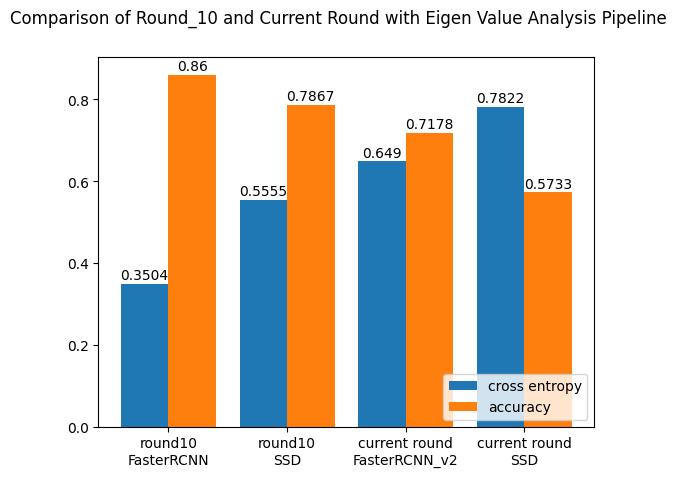

In [106]:
fig, ax = plt.subplots()
bar1 = ax.bar(np.arange(4)-.2, [0.3504, 0.5555, 0.6490, 0.7822], width=0.4, label='cross entropy')
bar2 = ax.bar(np.arange(4)+.2, [0.86, 0.7867, 0.7178, 0.5733], width=0.4, label='accuracy')
ax.set_xticks(np.arange(4), ['round10\nFasterRCNN', 'round10\nSSD', 'current round\nFasterRCNN_v2', 'current round\nSSD'])
ax.legend(loc=4)
ax.bar_label(bar1, padding=1)
ax.bar_label(bar2, padding=1)
plt.suptitle('Comparison of Round_10 and Current Round with Eigen Value Analysis Pipeline')
# fig.tight_layout()
plt.show()

1. FasterRCNN cen - 0.7044 acc - 0.6000  (1266 weight, 360 eigen features)
2. SSD cen - 0.7455 acc - 0.5267  (438 weight, 175 eigen features)

1. weight analysis pipeline - look deeper into weight stats and eigen - layer difference
2. trigger inversion pipeline - try similar experiment as image-classification round, adding sample triggers -> analyze classification/localization (bounding box)/injection (more detection appears)